## Antonym Analysis 

In this notebook, we are going to study if the embedding of an adjective an its antonym are really far away as what we expected.

In [1]:
# install the faiss-cpu when new env is provisioned
#conda install -c pytorch faiss-cpu=1.7.4 mkl=2021

# install the openai when new env is provisioned
#conda install -c conda-forge openai

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import umap
import openai
import pandas as pd
import numpy as np
import altair as alt
import configparser
import session_info
from PIL import Image

#alt.data_transformers.disable_max_rows()

### Prepare required resources

In [3]:
# Load your API key from an environment variable or secret management service
config = configparser.ConfigParser()
config.read('nes.ini')
openai.api_key = config['OpenAI']['api_key']

### Define helper functions

In [4]:
# Helper function to create the query embedding. Make sure to use the same model as what we used to created the product embedding
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   
   return np.array(openai.Embedding.create(input = [text], model=model)['data'][0]['embedding'], dtype='float32').reshape(1, -1)

In [5]:
# make a func to handle the mixed- type data and return the final UMAP embeddings
def umap_embed(df, n_components=2,  n_neighbors= 15, random_state=42):
    reducer = umap.UMAP(random_state=random_state, n_components=n_components, n_neighbors=n_neighbors, metric='cosine')
    reducer.fit(df)
    umap_embedding = reducer.transform(df)
   
    return reducer, umap_embedding

### Prepare data for the distance analysis

In [6]:
# Create a dataframe containing the adjectives and their antonyms from one of the testing query 
df_adj = pd.DataFrame(['Long','Short','Thin','Thick','Breathable','Stuffy','Cool','Hot'], columns=['adjective'])

# Create embeddings
df_adj['embedding'] = df_adj['adjective'].apply(lambda x: get_embedding(x)[0])

df_adj

,adjective,embedding
0,Long,"[0.0048255734, 0.0027919388, 0.016544823, -0.0..."
1,Short,"[-0.01411955, 0.009450202, 0.009687154, -0.007..."
2,Thin,"[-0.012029518, -0.005202453, 0.0058670673, 0.0..."
3,Thick,"[-0.015147983, -0.008822895, -0.0086416025, -0..."
4,Breathable,"[-0.010360341, 0.012756744, -0.011476474, -0.0..."
5,Stuffy,"[-0.0042448253, -0.010555807, -0.008107787, -0..."
6,Cool,"[-0.009752826, -0.005435001, 0.015460701, -0.0..."
7,Hot,"[-0.028340444, -0.0046487427, -0.0106000975, -..."


### Create visualization 

In [7]:
# Reduce the dimension of word embedding to 2
df_adj_vector = pd.DataFrame(df_adj['embedding'].values.tolist()).add_prefix('data')
_ , umap_adj = umap_embed(df_adj_vector, n_components=2)

In [8]:
df_adj['comp1'] = pd.Series(umap_adj[:,0])
df_adj['comp2'] = pd.Series(umap_adj[:,1])

In [9]:
# In order to create consistent result for the scatter plot, we save the df_adj here
# Then we reload 
#df_adj.to_csv('../resources/data/temp/df_adj.csv', index=False)
df_adj = pd.read_csv('../resources/data/temp/df_adj.csv')

In [10]:
df_adj = pd.read_csv('../resources/data/temp/df_adj.csv')

In [11]:
annotations = [[0.6, 5.5, 'Breathable'],
               [1.2, 5.0, 'Stuffy'],
               [1.3, 6.3, 'Thick'],
               [1.8, 7.0, 'Thin'],
               [2.0, 3.5, 'Cool'],
               [2.1, 5.5, 'Hot'],
               [2.5, 6.5, 'Short'],
               [3.0, 6.0, 'Long']]
               
df_ann = pd.DataFrame(annotations, columns=['comp1', 'comp2', 'adjective'])

In [12]:
scatter_plot = alt.Chart(data=df_adj).mark_circle(size=200, color='orange').encode(
        x=alt.X('comp1:Q').scale(domain=(0,4)),
        y=alt.Y('comp2:Q').scale(domain=(0,8)),
        tooltip=[
            'adjective:N'
            ]
)

ann_plot = alt.Chart(data=df_ann).mark_text(fontSize=15).encode(
    x=alt.X('comp1:Q'),
    y=alt.Y('comp2:Q'),
    text=alt.Text('adjective:N')
)

plot = (scatter_plot + ann_plot).properties(
    width=600,
    height=400
)

plot.display()

alt.LayerChart(...)

In [13]:
plot.save('img/scatter.png')

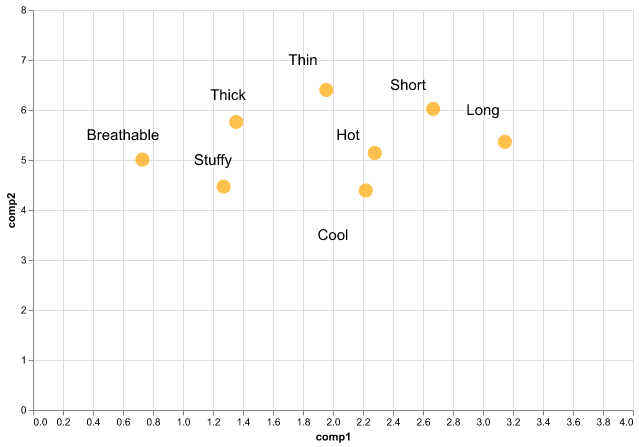

In [14]:

Image.open('img/scatter.png')

### List of libraries used

In [15]:
session_info.show()